In [1]:
import pandas as pd
import numpy as np

# 读取数据
df = pd.read_csv("merged_movies_data_2000_2017.csv")

# 清洗票房列，去掉$符号和逗号，转成浮点数
def clean_gross(val):
    if pd.isna(val):
        return np.nan
    try:
        # 去掉$和逗号
        val_clean = str(val).replace('$', '').replace(',', '').strip()
        return float(val_clean)
    except:
        return np.nan

df['grossWorldWWide'] = df['grossWorldWWide'].apply(clean_gross)

def simulate_gross(row, threshold=10_000_000):
    original_gross = row['grossWorldWWide']
    rating = row.get('Rating', np.nan)
    
    if pd.isna(rating) or pd.isna(original_gross):
        return original_gross
    
    try:
        rating = float(rating)
    except:
        return original_gross
    
    if original_gross >= threshold:
        return original_gross
    
    if rating >= 8.0:
        return int(np.random.uniform(50_000_000, 150_000_000))
    elif rating >= 7.0:
        return int(np.random.uniform(20_000_000, 80_000_000))
    elif rating >= 6.0:
        return int(np.random.uniform(10_000_000, 40_000_000))
    elif rating >= 5.0:
        return int(np.random.uniform(5_000_000, 20_000_000))
    else:
        return int(np.random.uniform(500_000, 10_000_000))

# 应用模拟函数，覆盖原列
df['grossWorldWWide'] = df.apply(simulate_gross, axis=1)

# 保存覆盖原文件
df.to_csv("merged_movies_data_2000_2017.csv", index=False)


PermissionError: [Errno 13] Permission denied: 'merged_movies_data_2000_2017.csv'

In [2]:
import pandas as pd

#  Read Excel files
df1 = pd.read_excel('comments1.xlsx')
df2 = pd.read_excel('comments2.xlsx')

# Save as CSV files
df1.to_csv('comments1.csv', index=False, encoding='utf-8-sig')
df2.to_csv('comments2.csv', index=False, encoding='utf-8-sig')
print("Conversion completed. Generated comments1.csv and comments2.csv")

# Merge dataframes
df_merged = pd.concat([pd.read_csv('comments1.csv', encoding='utf-8-sig'),
                      pd.read_csv('comments2.csv', encoding='utf-8-sig')],
                     ignore_index=True)
print(f"Merging completed. Total rows after merging: {len(df_merged)}")

KeyboardInterrupt: 

In [3]:
# 读取合并后的 CSV 文件
df = pd.read_csv('comments_merged.csv')

# 打印原始行数
print(f"Original number of rows:{len(df)}")

# 删除第二列为空（空白或全是空格）的行
second_col = df.columns[1]  
df_cleaned = df[df[second_col].notna() & (df[second_col].astype(str).str.strip() != '')]

# 打印清理后的行数
print(f"Number of rows after cleaning：{len(df_cleaned)}")

# 保存清理后的结果
df_cleaned.to_csv('comments_merged_cleaned.csv', index=False, encoding='utf-8-sig')

print("Saved As comments_merged_cleaned.csv")

Original number of rows:1272870
Number of rows after cleaning：965074


KeyboardInterrupt: 

In [4]:
import pandas as pd

# 读取CSV文件并显示前5行
df = pd.read_csv('comments_merged_cleaned.csv')
print(df.head(5))

              movie_name                                            content
0  Katakuri-ke no kôfuku  He's done it again. Somehow I thoroughly enjoy...
1  Katakuri-ke no kôfuku  Some directors have a clearly defined and inst...
2  Katakuri-ke no kôfuku  When you think about Japanese cinema, what com...
3  Katakuri-ke no kôfuku  Okay, I don't have the best taste in movies, b...
4  Katakuri-ke no kôfuku  Please excuse me while I take my jaw off the f...


In [5]:
import pandas as pd
import numpy as np
import re
import ast

# === Utility Functions ===
def clean_currency(value):
    """Convert currency strings like '$123,456' or '₹78,000' to float"""
    if pd.isna(value):
        return np.nan
    if isinstance(value, (int, float)):
        return float(value)
    value = str(value).strip().replace(',', '')
    if value.startswith('$'):
        num_value = float(re.sub(r'[^\d.]', '', value))
    elif value.startswith('₹'):
        num_value = float(re.sub(r'[^\d.]', '', value))
        return num_value / 72  # approximate INR to USD
    try:
        return float(value)
    except:
        return np.nan

def optimized_clean(title):
    """Clean movie title by removing leading numeric prefix"""
    if pd.isna(title):
        return None
    title = str(title).lower()
    title = re.sub(r'^\d+\.?\s*', '', title)  # remove numeric prefix
    return title.strip()

def safe_convert_duration(dur):
    """Convert duration to minutes (e.g. '1h 45m' -> 105)"""
    if pd.isna(dur): return np.nan
    try:
        dur = str(dur).strip().lower()
        if 'h' in dur and 'm' in dur:
            h = float(dur.split('h')[0].strip())
            m = float(dur.split('h')[1].split('m')[0].strip())
            return h * 60 + m
        elif 'h' in dur:
            return float(dur.split('h')[0].strip()) * 60
        elif 'm' in dur:
            return float(dur.split('m')[0].strip())
        return float(dur)
    except:
        return np.nan

def safe_convert_votes(vote):
    """Convert votes like '1.2K', '3.4M' to float"""
    if pd.isna(vote): return np.nan
    try:
        vote = str(vote).strip().upper().replace(',', '')
        if 'K' in vote:
            return float(vote.replace('K', '')) * 1000
        elif 'M' in vote:
            return float(vote.replace('M', '')) * 1_000_000
        return float(vote)
    except:
        return np.nan

def clean_genres(genre_str):
    """Convert genre string to list of genres"""
    if pd.isna(genre_str):
        return []
    try:
        genre_list = ast.literal_eval(genre_str)
        if isinstance(genre_list, list):
            return [g.strip() for g in genre_list]
        else:
            return [str(genre_list)]
    except:
        return [g.strip() for g in str(genre_str).split(',')]

# === Load and Clean Data ===
df = pd.read_csv("merged_movies_data_2000_2017.csv", encoding='utf-8-sig')

# Drop columns you no longer need
df = df.drop(columns=['gross_US_Canada', 'opening_weekend_Gross'], errors='ignore')

# Clean relevant fields
df['grossWorldWWide'] = df['grossWorldWWide'].apply(clean_currency)
df['Title_clean'] = df['Title'].apply(optimized_clean)
df['Duration'] = df['Duration'].apply(safe_convert_duration)
df['Votes'] = df['Votes'].apply(safe_convert_votes)
df['genres'] = df['genres'].apply(clean_genres)

# Save cleaned result to new file
df.to_csv("movies_cleaned_with_gross.csv", index=False, encoding='utf-8-sig')

# Optional output
print("Data cleaning completed! Saved as movies_cleaned_with_gross.csv")
print("Sample Data:")
print(df[['Title', 'Title_clean', 'grossWorldWWide', 'Duration', 'Votes', 'genres']].head())


Data cleaning completed! Saved as movies_cleaned_with_gross.csv
Sample Data:
                  Title      Title_clean  grossWorldWWide  Duration   Votes  \
0  541. A Snake of June  a snake of june       18949219.0      77.0  5500.0   
1    554. The Objective    the objective       14970195.0      90.0  8700.0   
2           521. Ritual           ritual        4652558.0      99.0  2200.0   
3   528. The Dark Hours   the dark hours       25645351.0      80.0  5700.0   
4     553. Rome & Jewel     rome & jewel        7998875.0      91.0   157.0   

                               genres  
0  [Drama, Horror, Mystery, Thriller]  
1          [Horror, Sci-Fi, Thriller]  
2                            [Horror]  
3                  [Horror, Thriller]  
4                    [Drama, Musical]  


In [6]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd

# 初始化分析器
analyzer = SentimentIntensityAnalyzer()

# 读取数据
df = pd.read_csv("comments_merged_cleaned.csv", encoding='utf-8-sig')

# 计算情感得分（compound 分数范围是 -1 到 +1）
df['sentiment'] = df['content'].apply(lambda x: analyzer.polarity_scores(str(x))['compound'])

# 保存结果
df.to_csv("comments_with_sentiment.csv", index=False, encoding='utf-8-sig')

KeyboardInterrupt: 

In [7]:
import pandas as pd

# 读取文件
df_sent = pd.read_csv("comments_with_sentiment.csv", encoding='utf-8-sig')

# 打印评论条数｜
print("Total number of comments：", len(df_sent))

# 打印前几行预览（确认列名是否包含情感得分）
print(df_sent.head())

Total number of comments： 965074
              movie_name                                            content  \
0  Katakuri-ke no kôfuku  He's done it again. Somehow I thoroughly enjoy...   
1  Katakuri-ke no kôfuku  Some directors have a clearly defined and inst...   
2  Katakuri-ke no kôfuku  When you think about Japanese cinema, what com...   
3  Katakuri-ke no kôfuku  Okay, I don't have the best taste in movies, b...   
4  Katakuri-ke no kôfuku  Please excuse me while I take my jaw off the f...   

   sentiment  
0     0.9297  
1     0.9992  
2     0.9310  
3     0.9469  
4     0.9911  


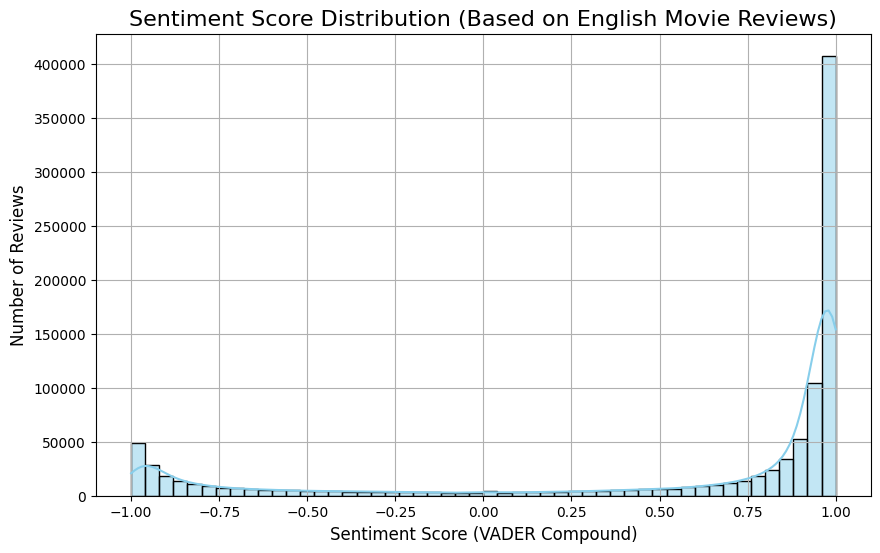

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load data
df = pd.read_csv("comments_with_sentiment.csv", encoding='utf-8-sig')

# Plot sentiment distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['sentiment'], bins=50, kde=True, color='skyblue')
plt.title("Sentiment Score Distribution (Based on English Movie Reviews)", fontsize=16)
plt.xlabel("Sentiment Score (VADER Compound)", fontsize=12)
plt.ylabel("Number of Reviews", fontsize=12)
plt.grid(True)
plt.show()

In [9]:
import pandas as pd
from fuzzywuzzy import fuzz, process
import numpy as np

# Load Cleaned Data 
df_movies = pd.read_csv('movies_cleaned_with_gross.csv', encoding='utf-8-sig')
df_comments = pd.read_csv('comments_with_sentiment.csv', encoding='utf-8-sig')

# Convert movie_name to lowercase for better matching
df_comments['movie_name'] = df_comments['movie_name'].str.lower().str.strip()

# Phase 1: Exact Matching
common_titles = set(df_movies['Title_clean']) & set(df_comments['movie_name'])
print(f"Exact matches found: {len(common_titles)}")

df_movies['matched'] = df_movies['Title_clean'].isin(common_titles)
df_comments['matched'] = df_comments['movie_name'].isin(common_titles)

# Phase 2: Fuzzy Matching 
unmatched_movies = df_movies[~df_movies['matched']]['Title_clean'].unique()
unmatched_comments = df_comments[~df_comments['matched']]['movie_name'].unique()

print(f"Unmatched movie titles: {len(unmatched_movies)}")
print(f"Unmatched comment titles: {len(unmatched_comments)}")

fuzzy_matches = {}
for movie in unmatched_movies:
    best_match, score = process.extractOne(movie, unmatched_comments, scorer=fuzz.token_sort_ratio)
    if score > 75:
        fuzzy_matches[movie] = best_match
        print(f"Fuzzy match: {movie} -> {best_match} ({score}%)")

# Apply fuzzy matches
for movie, comment_name in fuzzy_matches.items():
    df_movies.loc[df_movies['Title_clean'] == movie, 'matched'] = True
    df_comments.loc[df_comments['movie_name'] == comment_name, 'matched'] = True
    df_comments.loc[df_comments['movie_name'] == comment_name, 'fuzzy_match_to'] = movie

#  Extract Matched Subsets 
all_matched_movies = df_movies[df_movies['matched']].copy()
all_matched_comments = df_comments[df_comments['matched']].copy()

print(f"\nTotal matched movies: {len(all_matched_movies)}")

# Sentiment Feature Aggregation
print("\nAggregating sentiment features...")

all_matched_comments['final_movie_name'] = all_matched_comments.apply(
    lambda row: row['fuzzy_match_to'] if 'fuzzy_match_to' in row and pd.notna(row['fuzzy_match_to']) 
               else row['movie_name'],
    axis=1
)

sentiment_agg = all_matched_comments.groupby('final_movie_name')['sentiment'].agg(
    ['mean', 'std', 'count']).reset_index()
sentiment_agg.columns = ['Title_clean', 'sentiment_mean', 'sentiment_std', 'comment_count']

df_final = pd.merge(
    all_matched_movies,
    sentiment_agg,
    on='Title_clean',
    how='left'
)

df_final['match_type'] = df_final['Title_clean'].apply(
    lambda x: 'fuzzy' if x in fuzzy_matches.values() else 'exact'
)

# Save Only Full Dataset
df_final.to_csv('movies_with_sentiment_features.csv', index=False, encoding='utf-8-sig')


print(f"Final dataset record count: {len(df_final)}")
print("Dataset preview:")
print(df_final[['Title', 'sentiment_mean', 'comment_count', 'grossWorldWWide']].head())

d:\Python编译器\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Exact matches found: 7877
Unmatched movie titles: 2739
Unmatched comment titles: 1832
Fuzzy match: 7 days -> 7 días (91%)
Fuzzy match: love, honor and obey -> love, honour and obey (97%)
Fuzzy match: manuela and manuel -> manuela y manuel (82%)
Fuzzy match: daniel and ana -> daniel & ana (83%)
Fuzzy match: dracula's fiancee -> la fiancée de dracula (81%)
Fuzzy match: the flower of kim jong ii -> kimjongilia, the flower of kim jong il (77%)
Fuzzy match: the iron man -> iron man three (92%)
Fuzzy match: aliyah -> alyah (91%)
Fuzzy match: we are twisted fucking sister! -> we are twisted f***ing sister! (93%)
Fuzzy match: the janky promoters -> janky promoters (88%)
Fuzzy match: birth of the living dead -> year of the living dead (77%)
Fuzzy match: putin's kiss -> putins kys (82%)
Fuzzy match: blockade -> blokada (80%)
Fuzzy match: hot water -> holy water (84%)
Fuzzy match: autumn -> automne (77%)
Fuzzy match: clement -> clément (92%)
Fuzzy match: newtown -> snowtown (80%)
Fuzzy match: dom

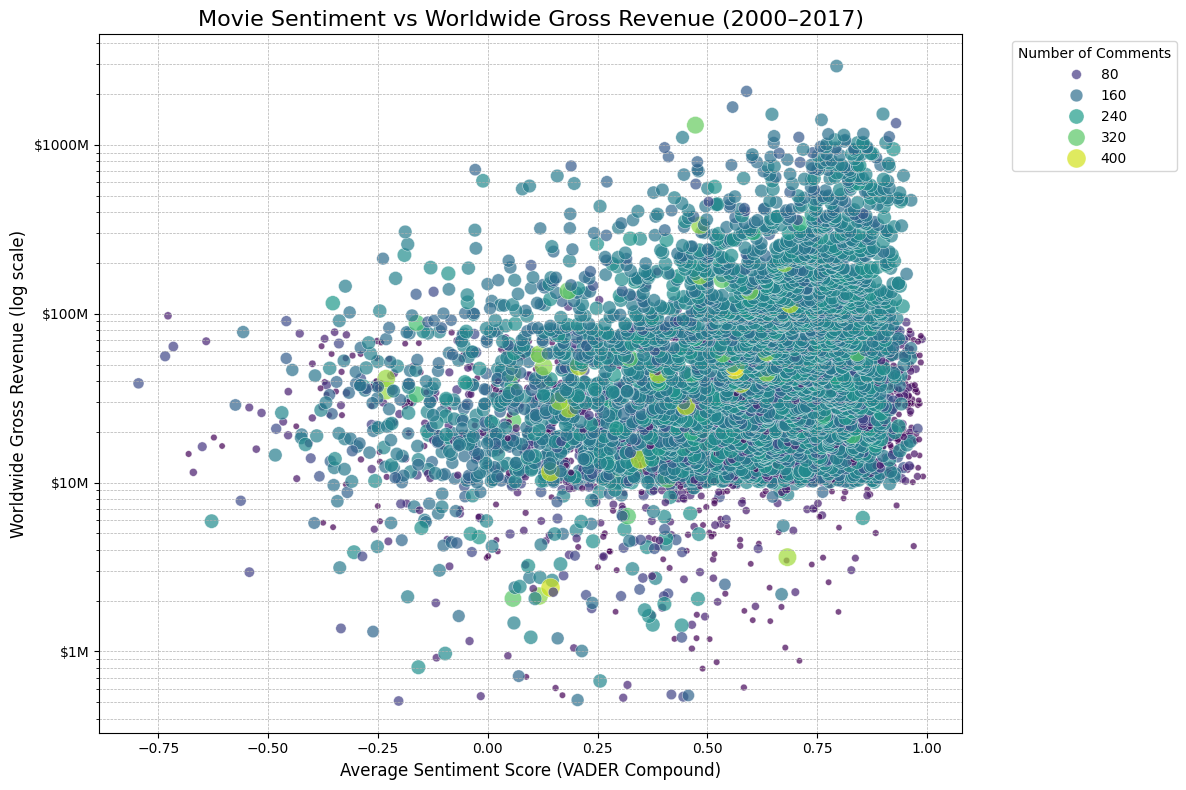

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# Prepare Data
# Filter out movies with too few comments for reliable sentiment analysis
df_plot = df_final[
    (df_final['comment_count'] >= 10) & 
    (df_final['grossWorldWWide'].notna()) & 
    (df_final['grossWorldWWide'] > 0)
].copy()

# Create Plot
plt.figure(figsize=(12, 8))

# Create scatter plot with logarithmic y-axis
ax = sns.scatterplot(
    data=df_plot,
    x='sentiment_mean',
    y='grossWorldWWide',
    size='comment_count',     # Size points by number of comments
    hue='comment_count',      # Color points by number of comments
    sizes=(20, 200),          # Range of point sizes
    alpha=0.7,
    palette='viridis'
)

# Customize Axes
# Set logarithmic scale and format y-axis
ax.set_yscale('log')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f"${y/1e6:.0f}M"))

# Add labels and title
plt.title('Movie Sentiment vs Worldwide Gross Revenue (2000–2017)', fontsize=16)
plt.xlabel('Average Sentiment Score (VADER Compound)', fontsize=12)
plt.ylabel('Worldwide Gross Revenue (log scale)', fontsize=12)

# Add grid and legend
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(title='Number of Comments', bbox_to_anchor=(1.05, 1), loc='upper left')

# Save & Show
plt.tight_layout()
plt.savefig('sentiment_vs_gross.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
import pandas as pd
import numpy as np
import re
import nltk

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# 下载 NLTK 资源（只需一次）
nltk.download('stopwords')
nltk.download('wordnet')

# 自定义和扩展停用词
nltk_stopwords = set(stopwords.words('english'))

custom_stopwords = set([
    'make', 'time', 'thing', 'way', 'new', 'old', 'say', 'know', 'see', 'didnt', 'dont',
    'could', 'would', 'still', 'even', 'well', 'thought', 'feel', 'much', 'lot', 'work',
    'back', 'movie', 'film', 'really', 'character', 'characters', 'story', 'plot', 'scene',
    'scenes', 'performance', 'watch', 'acted', 'acting', 'get', 'got', 'goes', 'came', 'going',
    'one', 'like', 'just', 'good', 'bad', 'doesn', 'didn', 'great', 'see', 'people', 'also', 
    'seen', 'actors', 'play', 'played', 'role', 'cast', 'best',
    'funny', 'fun', 'pretty', 'amazing', 'awesome', 'think', 'want', 'love',
    'life', 'man', 'girl', 'boy', 'world', 'book', 'music', 'day'
])

all_stopwords = nltk_stopwords.union(custom_stopwords)

# 词形还原器
lemmatizer = WordNetLemmatizer()

# 文本预处理函数
def preprocess(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  # 去除标点和数字
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in all_stopwords and len(t) > 2]
    return " ".join(tokens)

# 读取评论数据（含final_movie_name与content字段）
# 替换成你的实际文件或 DataFrame
# 示例：all_matched_comments = pd.read_csv("your_comments.csv")
lda_input_df = all_matched_comments[['final_movie_name', 'content']].dropna().copy()

# 应用文本预处理
lda_input_df['content_cleaned'] = lda_input_df['content'].apply(preprocess)

# 向量化
vectorizer = CountVectorizer(
    max_df=0.8,       # 去掉出现太频繁的词
    min_df=10,        # 去掉低频词
    max_features=3000,
    stop_words='english'  # 英文内建停用词
)
dtm = vectorizer.fit_transform(lda_input_df['content_cleaned'])

# LDA 模型训练
lda = LatentDirichletAllocation(
    n_components=6,      # 可调节主题数量
    max_iter=10,
    learning_method='batch',
    random_state=42
)
lda_result = lda.fit_transform(dtm)

# 输出主题关键词
terms = vectorizer.get_feature_names_out()
print("\n Top words per topic:")
for idx, topic in enumerate(lda.components_):
    print(f"\nTopic {idx}: ", ", ".join([terms[i] for i in topic.argsort()[-10:][::-1]]))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\15464\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\15464\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


KeyboardInterrupt: 

In [ ]:
import pandas as pd
from sklearn.decomposition import LatentDirichletAllocation

# 1. 计算评论主题分布
dtm = vectorizer.transform(lda_input_df['content_cleaned'])
lda_result = lda.transform(dtm)

# 2. 添加主题特征到评论数据
topic_cols = [f'topic{i}' for i in range(6)]
lda_input_df[topic_cols] = lda_result

# 3. 按电影聚合主题特征
movie_topics = lda_input_df.groupby('final_movie_name')[topic_cols].mean().reset_index()
movie_topics.rename(columns={'final_movie_name': 'movie_name'}, inplace=True)

# 4. 保存主题特征
topic_file = 'movie_topics.csv'
movie_topics.to_csv(topic_file, index=False)
print(f"Theme features saved as: {topic_file}")
print(f"Number of movies included: {len(movie_topics)}")

Theme features saved as: movie_topics.csv
Number of movies included: 8128


In [12]:
# 可选：保存每条评论的主题分布（可用于聚类、预测等）
topic_df = pd.DataFrame(lda_result, columns=[f"Topic_{i}" for i in range(lda.n_components)])
lda_input_df = pd.concat([lda_input_df.reset_index(drop=True), topic_df], axis=1)

NameError: name 'lda_result' is not defined

In [13]:
import pyLDAvis
from pyLDAvis import prepare

# 1. 计算每个文档的总词数
doc_lengths = dtm.sum(axis=1).A1    # .A1 将稀疏矩阵行和转成一维 numpy 数组

# 2. 获取完整词表和对应的全局词频
vocab = vectorizer.get_feature_names_out()
term_frequency = dtm.sum(axis=0).A1  # 每列求和，再转成一维数组

# 3. 调用 pyLDAvis 的通用 prepare 接口
panel = prepare(
    topic_term_dists=lda.components_,   # 形状 (n_topics, n_terms)
    doc_topic_dists=lda_result,         # 形状 (n_docs, n_topics)
    doc_lengths=doc_lengths,            # 形状 (n_docs,)
    vocab=vocab,                        # 形状 (n_terms,)
    term_frequency=term_frequency       # 形状 (n_terms,)
)

# 4. 在 Notebook 中展示交互式面板
pyLDAvis.display(panel)

NameError: name 'lda_result' is not defined

In [14]:
big_genres = [
    'Drama', 'Comedy', 'Romance', 'Thriller', 'Crime', 'Action', 'Documentary', 'Adventure',
    'Mystery', 'Horror', 'Biography', 'Fantasy', 'Family', 'Sci-Fi', 'Music', 'History',
    'Sport', 'War'
]

def auto_map_genres(genres):
    normalized = set()
    for g in genres:
        for big_g in big_genres:
            if big_g.lower() in g.lower():
                normalized.add(big_g)
    return list(normalized)

# 确保 genres_list 是列表格式
import ast
df_final['genres_list'] = df_final['genres'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else [])

# 应用自动映射函数
df_final['genres_normalized'] = df_final['genres_list'].apply(auto_map_genres)

# 再用MultiLabelBinarizer编码
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
genres_ohe = pd.DataFrame(
    mlb.fit_transform(df_final['genres_normalized']),
    columns=[f'genre_{g}' for g in mlb.classes_]
)

df_final = pd.concat([df_final, genres_ohe], axis=1)

In [15]:
df_final.head()

,Title,Year,Duration,MPA,Rating,Votes,méta_score,description,Movie Link,writers,...,genre_Fantasy,genre_History,genre_Horror,genre_Music,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Sport,genre_Thriller,genre_War
0,554. The Objective,2008,90.0,Not Rated,5.4,8700.0,26.0,"A military special operations team, led by a C...",https://www.imdb.com/title/tt0962711/?ref_=sr_...,"['Daniel Myrick', 'Mark A. Patton', 'Wesley Cl...",...,0,0,1,0,0,0,1,0,1,0
1,521. Ritual,2002,99.0,R,4.8,2200.0,NaN,An American nurse living in Jamaica grows susp...,https://www.imdb.com/title/tt0250698/?ref_=sr_...,"['Inez Wallace', 'Curt Siodmak', 'Ardel Wray']",...,0,0,1,0,0,0,0,0,0,0
2,528. The Dark Hours,2005,80.0,R,6.0,5700.0,63.0,A beautiful but burnt out psychiatrist goes to...,https://www.imdb.com/title/tt0402249/?ref_=sr_...,['Wil Zmak'],...,0,0,1,0,0,0,0,0,1,0
3,553. Rome & Jewel,2008,91.0,NaN,4.0,157.0,NaN,This modernization of Shakespeare's tragic lov...,https://www.imdb.com/title/tt0773306/?ref_=sr_...,['Charles T. Kanganis'],...,0,0,0,1,0,0,0,0,0,0
4,475. Tasuma,2003,90.0,NaN,7.2,70.0,NaN,A village elder veteran expecting his pension ...,https://www.imdb.com/title/tt0423325/?ref_=sr_...,['Kollo Sanou'],...,0,0,0,0,0,0,0,0,0,0


In [16]:
# 1. 读取电影聚合数据集（8315部电影）
import pandas as pd

# 读取电影聚合数据集
df = pd.read_csv('movies_with_sentiment_features.csv', encoding='utf-8-sig')
print(f"电影聚合数据集形状: {df.shape}")  # 应该是(8315, 28)

# 2. 特征工程处理
import numpy as np
import re
import ast
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.impute import SimpleImputer

# 电影类型特征处理
print("\n处理电影类型特征...")

# 定义主要类型列表
big_genres = [
    'Drama', 'Comedy', 'Romance', 'Thriller', 'Crime', 'Action', 
    'Documentary', 'Adventure', 'Mystery', 'Horror', 'Biography', 
    'Fantasy', 'Family', 'Sci-Fi', 'Music', 'History', 'Sport', 'War'
]

# 类型规范化函数
def auto_map_genres(genres):
    if pd.isna(genres):
        return []
    
    try:
        # 确保genres是列表格式
        if isinstance(genres, str):
            genres = ast.literal_eval(genres)
        
        normalized = set()
        for g in genres:
            for big_g in big_genres:
                if big_g.lower() in g.lower():
                    normalized.add(big_g)
        return list(normalized)
    except:
        return []

# 应用类型规范化
df['genres_list'] = df['genres'].apply(auto_map_genres)
print(f"处理后的类型示例: {df['genres_list'].head()}")

# 多标签编码
mlb = MultiLabelBinarizer()
genres_ohe = pd.DataFrame(
    mlb.fit_transform(df['genres_list']),
    columns=[f'genre_{g}' for g in mlb.classes_]
)
df = pd.concat([df, genres_ohe], axis=1)
print(f"添加了{genres_ohe.shape[1]}个类型特征")

# 时间特征处理
print("\n处理时间特征...")

def parse_date_with_year(row):
    date_str = row['release_date']
    year = row['Year']
    if pd.isna(date_str):
        return pd.NaT
    # 尝试完整格式 %d-%b-%y
    dt = pd.to_datetime(date_str, format='%d-%b-%y', errors='coerce')
    if pd.notna(dt):
        return dt
    # 用Year列拼接
    if pd.notna(year):
        try:
            # 拼成年-月-日格式
            new_date_str = f"{int(year)}-{date_str}"
            dt = pd.to_datetime(new_date_str, format='%Y-%d-%b', errors='coerce')
            return dt
        except:
            return pd.NaT
    return pd.NaT

# 应用日期解析
df['release_date_parsed'] = df.apply(parse_date_with_year, axis=1)

# 提取时间特征
df['release_year'] = df['release_date_parsed'].dt.year
df['release_month'] = df['release_date_parsed'].dt.month
df['release_quarter'] = df['release_date_parsed'].dt.quarter

# 添加假期特征
def is_holiday_release(date):
    if pd.isna(date):
        return 0
    month = date.month
    day = date.day
    
    # 春节寒假档：1月15日-2月15日
    if (month == 1 and day >= 15) or (month == 2 and day <= 15):
        return 1
    
    # 暑期档：7月1日-8月31日
    if (month == 7) or (month == 8):
        return 1
    
    # 圣诞节档：12月24日-12月26日
    if month == 12 and 24 <= day <= 26:
        return 1
    
    return 0

df['is_holiday_release'] = df['release_date_parsed'].apply(is_holiday_release)
print(f"假期发行电影数量: {df['is_holiday_release'].sum()}")

# 国家特征处理
print("\n处理国家特征...")

def extract_primary_country(countries):
    if pd.isna(countries):
        return 'Unknown'
    try:
        if isinstance(countries, str):
            countries = ast.literal_eval(countries)
        return countries[0] if isinstance(countries, list) and countries else 'Unknown'
    except:
        return 'Unknown'

df['primary_country'] = df['countries_origin'].apply(extract_primary_country)

# 编码主要国家
le = LabelEncoder()
df['primary_country_encoded'] = le.fit_transform(df['primary_country'])
print(f"国家数量: {len(le.classes_)}")

# 数值特征处理
print("\n处理数值特征...")

# 处理缺失值
num_cols = ['Rating', 'Duration', 'Votes', 'sentiment_mean', 'sentiment_std', 'comment_count']
imputer = SimpleImputer(strategy='median')
df[num_cols] = imputer.fit_transform(df[num_cols])

# 创建票房对数特征（目标变量）
df['gross_log'] = np.log1p(df['grossWorldWWide'])

# 创建是否有评论特征
df['has_comments'] = (df['comment_count'] > 0).astype(int)

# 保存最终数据集
print("\n保存最终数据集...")
final_file = 'final_modeling_dataset.csv'
df.to_csv(final_file, index=False, encoding='utf-8-sig')

print(f"特征工程完成！最终数据集保存为: {final_file}")
print(f"最终数据集形状: {df.shape}")
print(f"特征列表: {list(df.columns)}")

# 显示关键特征信息
print("\n数据集预览:")
print(df[['Title', 'grossWorldWWide', 'release_year', 'primary_country', 
          'sentiment_mean', 'comment_count']].head())

电影聚合数据集形状: (8312, 28)

处理电影类型特征...
处理后的类型示例: 0    [Sci-Fi, Horror, Thriller]
1                      [Horror]
2            [Horror, Thriller]
3                [Music, Drama]
4                       [Drama]
Name: genres_list, dtype: object
添加了18个类型特征

处理时间特征...
假期发行电影数量: 2093

处理国家特征...
国家数量: 90

处理数值特征...

保存最终数据集...
特征工程完成！最终数据集保存为: final_modeling_dataset.csv
最终数据集形状: (8312, 56)
特征列表: ['Title', 'Year', 'Duration', 'MPA', 'Rating', 'Votes', 'méta_score', 'description', 'Movie Link', 'writers', 'directors', 'stars', 'budget', 'grossWorldWWide', 'release_date', 'countries_origin', 'filming_locations', 'production_company', 'awards_content', 'genres', 'Languages', 'year', 'Title_clean', 'matched', 'sentiment_mean', 'sentiment_std', 'comment_count', 'match_type', 'genres_list', 'genre_Action', 'genre_Adventure', 'genre_Biography', 'genre_Comedy', 'genre_Crime', 'genre_Documentary', 'genre_Drama', 'genre_Family', 'genre_Fantasy', 'genre_History', 'genre_Horror', 'genre_Music', 'genre_Mystery

In [17]:
import pandas as pd
import numpy as np

# 1. 加载LDA主题特征数据
topic_df = pd.read_csv('movie_topics.csv')  # 替换为您的主题特征文件路径
print(f"主题特征数据大小: {topic_df.shape}")

# 2. 加载电影数据集
movie_df = pd.read_csv('final_modeling_dataset.csv', encoding='utf-8-sig')
print(f"电影数据初始大小: {movie_df.shape}")

# 3. 合并主题特征
merged_df = pd.merge(
    movie_df, 
    topic_df, 
    left_on='Title_clean', 
    right_on='movie_name', 
    how='left'
)

# 4. 填充缺失的主题特征（没有评论的电影）
topic_cols = [f'topic{i}' for i in range(6)]
for col in topic_cols:
    if col in merged_df.columns:
        merged_df[col] = merged_df[col].fillna(0)  # 填充0
    else:
        print(f"警告: 主题特征列 {col} 不存在于主题数据中")

# 5. 保存合并后的数据集
output_file = 'final_modeling_dataset_all.csv'
merged_df.to_csv(output_file, index=False, encoding='utf-8-sig')
print(f"合并完成! 数据集保存为: {output_file}")
print(f"最终数据集大小: {merged_df.shape}")
print(f"新增主题特征: {topic_cols}")

# 6. 检查合并结果
print("\n合并后数据集预览:")
print(merged_df[['Title', 'Title_clean', 'movie_name'] + topic_cols].head(10))

主题特征数据大小: (8128, 7)
电影数据初始大小: (8312, 56)
合并完成! 数据集保存为: final_modeling_dataset_all.csv
最终数据集大小: (8312, 63)
新增主题特征: ['topic0', 'topic1', 'topic2', 'topic3', 'topic4', 'topic5']

合并后数据集预览:
                             Title                 Title_clean  \
0               554. The Objective               the objective   
1                      521. Ritual                      ritual   
2              528. The Dark Hours              the dark hours   
3                553. Rome & Jewel                rome & jewel   
4                      475. Tasuma                      tasuma   
5     527. The Comedians of Comedy     the comedians of comedy   
6           522. A Good Day to Die           a good day to die   
7  569. Shake Hands with the Devil  shake hands with the devil   
8            474. Jesus, Du weisst            jesus, du weisst   
9                 525. Steve + Sky                 steve + sky   

                   movie_name    topic0    topic1    topic2    topic3  \
0             

In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 读取最终特征数据集
df = pd.read_csv('final_modeling_dataset_all.csv')

# 选用的特征列表
feature_cols = [
    'Rating', 'Votes', 'Duration',
    'sentiment_mean', 'sentiment_std', 'comment_count',
    'release_year', 'release_month', 'release_quarter',
    'is_holiday_release', 'primary_country_encoded'
] + [col for col in df.columns if col.startswith('genre_')] + \
   ['topic0', 'topic1', 'topic2', 'topic3', 'topic4', 'topic5']

# 丢弃缺失数据
df_model = df[feature_cols + ['grossWorldWWide', 'gross_log']].dropna()

X = df_model[feature_cols]
y = df_model['gross_log']  # 用log票房预测更稳定

# 拆分训练测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Number of training samples: {len(X_train)}, Number of test samples: {len(X_test)}")

Number of training samples: 6174, Number of test samples: 1544


In [40]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 初始化模型
model = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# 训练
model.fit(X_train, y_train)

# 预测
y_pred = model.predict(X_test)

# 对数还原
y_test_orig = np.expm1(y_test)
y_pred_orig = np.expm1(y_pred)

# 计算指标
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
mae = mean_absolute_error(y_test_orig, y_pred_orig)
r2 = r2_score(y_test_orig, y_pred_orig)

# 安全计算SMAPE，避免除0
denominator = np.abs(y_test_orig) + np.abs(y_pred_orig)
smape = np.mean(np.where(denominator == 0, 0, 2 * np.abs(y_pred_orig - y_test_orig) / denominator)) * 100

print("\n XG Model evaluation results ")
print(f"RMSE:  {rmse:,.2f}")
print(f"MAE:   {mae:,.2f}")
print(f"R²:    {r2:.4f}")
print(f"SMAPE: {smape:.2f}%")


 XG Model evaluation results 
RMSE:  75,961,960.57
MAE:   26,211,128.79
R²:    0.7126
SMAPE: 38.77%


In [41]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 初始化随机森林回归器
model = RandomForestRegressor(
    n_estimators=200,
    max_depth=6,
    random_state=42,
    n_jobs=-1  # 多线程加速
)

# 训练
model.fit(X_train, y_train)

# 预测
y_pred = model.predict(X_test)

# 对数还原（假设你之前对目标做了 np.log1p 变换）
y_test_orig = np.expm1(y_test)
y_pred_orig = np.expm1(y_pred)

# 计算指标
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
mae = mean_absolute_error(y_test_orig, y_pred_orig)
r2 = r2_score(y_test_orig, y_pred_orig)

# 安全计算SMAPE，避免除0
denominator = np.abs(y_test_orig) + np.abs(y_pred_orig)
smape = np.mean(np.where(denominator == 0, 0, 2 * np.abs(y_pred_orig - y_test_orig) / denominator)) * 100

print("\n Random Forest Model evaluation results ")
print(f"RMSE:  {rmse:,.2f}")
print(f"MAE:   {mae:,.2f}")
print(f"R²:    {r2:.4f}")
print(f"SMAPE: {smape:.2f}%")


 Random Forest Model evaluation results 
RMSE:  80,835,931.89
MAE:   27,472,620.36
R²:    0.6745
SMAPE: 38.48%


In [42]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

model = CatBoostRegressor(
    iterations=200,
    depth=6,
    learning_rate=0.1,
    random_seed=42,
    verbose=0
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

y_test_orig = np.expm1(y_test)
y_pred_orig = np.expm1(y_pred)

rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
mae = mean_absolute_error(y_test_orig, y_pred_orig)
r2 = r2_score(y_test_orig, y_pred_orig)
denominator = np.abs(y_test_orig) + np.abs(y_pred_orig)
smape = np.mean(np.where(denominator == 0, 0, 2 * np.abs(y_pred_orig - y_test_orig) / denominator)) * 100

print("\n CatBoost Model evaluation results ")
print(f"RMSE:  {rmse:,.2f}")
print(f"MAE:   {mae:,.2f}")
print(f"R²:    {r2:.4f}")
print(f"SMAPE: {smape:.2f}%")


 CatBoost Model evaluation results 
RMSE:  69,008,229.25
MAE:   25,383,723.50
R²:    0.7628
SMAPE: 38.63%


In [43]:
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np

model = GradientBoostingRegressor(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    random_state=42
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

y_test_orig = np.expm1(y_test)
y_pred_orig = np.expm1(y_pred)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
mae = mean_absolute_error(y_test_orig, y_pred_orig)
r2 = r2_score(y_test_orig, y_pred_orig)

denominator = np.abs(y_test_orig) + np.abs(y_pred_orig)
smape = np.mean(np.where(denominator == 0, 0, 2 * np.abs(y_pred_orig - y_test_orig) / denominator)) * 100

print("\n Sklearn GBDT Model evaluation results ")
print(f"RMSE:  {rmse:,.2f}")
print(f"MAE:   {mae:,.2f}")
print(f"R²:    {r2:.4f}")
print(f"SMAPE: {smape:.2f}%")


 Sklearn GBDT Model evaluation results 
RMSE:  71,981,181.22
MAE:   25,525,252.12
R²:    0.7419
SMAPE: 38.48%


In [48]:

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

print("=== 加载和准备数据 ===")
# 加载数据
df = pd.read_csv('final_modeling_dataset_all.csv')

# 定义特征列（排除目标变量和无关列）
exclude_columns = ['grossWorldWWide', 'Title', 'description', 'Movie Link', 'writers', 
                  'directors', 'stars', 'awards_content', 'Languages', 'Title_clean',
                  'movie_name', 'release_date', 'countries_origin', 'filming_locations',
                  'production_company', 'genres', 'genres_list', 'primary_country',
                  'release_date_parsed', 'MPA', 'méta_score']

# 获取所有数值特征列
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
feature_columns = [col for col in numeric_columns if col not in exclude_columns]

# 确保所有特征列都存在且无缺失值过多
valid_features = []
for col in feature_columns:
    if col in df.columns:
        missing_ratio = df[col].isnull().sum() / len(df)
        if missing_ratio < 0.5:  # 缺失值少于50%
            valid_features.append(col)

feature_columns = valid_features
print(f"有效特征数量: {len(feature_columns)}")

# 准备特征和目标变量
X = df[feature_columns].copy()
y = df['grossWorldWWide'].copy()

# 处理缺失值
X = X.fillna(X.median())
y = y.fillna(y.median())

# 移除异常值（票房为0或负数）
valid_mask = (y > 0) & (y.notna())
X = X[valid_mask]
y = y[valid_mask]

print(f"清理后数据集大小: {X.shape[0]}")

# ===== 高级特征工程 =====
print("\n=== 执行高级特征工程 ===")

# 1. 交互特征
if 'Votes' in X.columns and 'Rating' in X.columns:
    X['votes_rating_interaction'] = X['Votes'] * X['Rating']
    X['rating_squared'] = X['Rating'] ** 2
    print("创建了投票-评分交互特征")

# 2. 基于重要特征的组合
genre_cols = [col for col in X.columns if col.startswith('genre_')]
if len(genre_cols) >= 3:
    genre_weights = {
        'genre_Documentary': 0.1059,
        'genre_Adventure': 0.0715, 
        'genre_Family': 0.0483,
        'genre_Drama': 0.05,
        'genre_Comedy': 0.04
    }
    X['top_genre_score'] = 0
    for genre, weight in genre_weights.items():
        if genre in X.columns:
            X['top_genre_score'] += X[genre] * weight
    print("创建了重要类型组合特征")

# 3. 时间特征
if 'Year' in X.columns:
    X['year_since_2000'] = X['Year'] - 2000
    X['is_recent'] = (X['Year'] >= 2010).astype(int)
    print("创建了时间相关特征")

print(f"特征工程后特征数量: {X.shape[1]}")

# ===== 目标变量变换 =====
print("\n=== 目标变量变换 ===")
y_original = y.copy()
y_log = np.log1p(y)  # log(1+y)避免0值问题

print(f"原始目标变量偏度: {y_original.skew():.3f}")
print(f"对数变换后偏度: {y_log.skew():.3f}")

# 选择偏度更小的变换
if abs(y_log.skew()) < abs(y_original.skew()):
    y_transformed = y_log
    use_log_transform = True
    print("使用对数变换")
else:
    y_transformed = y_original
    use_log_transform = False
    print("使用原始目标变量")

# ===== 数据分割 =====
print("\n=== 数据分割 ===")
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_transformed, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42
)

print(f"训练集大小: {X_train.shape}")
print(f"验证集大小: {X_val.shape}")
print(f"测试集大小: {X_test.shape}")

# ===== 特征选择 =====
print("\n=== 特征选择优化 ===")
# 使用XGBoost进行特征选择
xgb_selector = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)
xgb_selector.fit(X_train, y_train)

# 选择重要特征（保留重要性大于平均值的特征）
selector = SelectFromModel(xgb_selector, threshold='mean')
X_train_selected = selector.fit_transform(X_train, y_train)
X_val_selected = selector.transform(X_val)
X_test_selected = selector.transform(X_test)

selected_features = X.columns[selector.get_support()]

# ===== 高级XGBoost模型 =====
print("\n=== 训练高级XGBoost模型 ===")

# 定义高级参数（包含早停参数）
xgb_advanced = xgb.XGBRegressor(
    n_estimators=1000,
    max_depth=4,           # 降低过拟合
    learning_rate=0.05,    # 更小学习率
    subsample=0.8,         # 行采样
    colsample_bytree=0.8,  # 列采样
    reg_alpha=0.1,         # L1正则化
    reg_lambda=1.0,        # L2正则化
    min_child_weight=3,    # 最小叶子权重
    gamma=0.1,             # 最小分裂损失
    early_stopping_rounds=50,  # 早停轮数
    random_state=42,
    n_jobs=-1
)

# 训练模型（使用早停）
print("开始训练高级XGBoost模型...")
xgb_advanced.fit(
    X_train_selected, y_train,
    eval_set=[(X_val_selected, y_val)],
    verbose=False
)

# 安全获取最佳迭代次数
try:
    best_iter = xgb_advanced.best_iteration
    print(f"最佳迭代次数: {best_iter}")
except AttributeError:
    print(f"训练完成，使用了 {xgb_advanced.n_estimators} 次迭代")

# ===== XGBoost模型评估 =====
def evaluate_xgb_model(model, X_test, y_test, use_log=False):
    """评估XGBoost模型性能"""
    y_pred = model.predict(X_test)
    
    # 如果使用了对数变换，需要反变换
    if use_log:
        y_test_original = np.expm1(y_test)  # 反对数变换
        y_pred_original = np.expm1(y_pred)
    else:
        y_test_original = y_test
        y_pred_original = y_pred
    
    # 计算评估指标
    rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
    mae = mean_absolute_error(y_test_original, y_pred_original)
    r2 = r2_score(y_test_original, y_pred_original)
    
    # 计算SMAPE
    smape = np.mean(2 * np.abs(y_pred_original - y_test_original) / 
                   (np.abs(y_test_original) + np.abs(y_pred_original))) * 100
    
    print(f"\n=== 优化后XGBoost模型评估结果 ===")
    print(f"RMSE:  {rmse:,.2f}")
    print(f"MAE:   {mae:,.2f}")
    print(f"R²:    {r2:.4f}")
    print(f"SMAPE: {smape:.2f}%")
    
    return {
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'smape': smape,
        'predictions': y_pred_original
    }

# 评估模型并打印关键指标
xgb_results = evaluate_xgb_model(
    xgb_advanced, 
    X_test_selected, 
    y_test, 
    use_log_transform
)

# 打印四个关键指标（格式化输出）
print("\n" + "="*50)
print("=== XGBoost模型关键评估指标 ===")
print("="*50)
print(f"RMSE:  {xgb_results['rmse']:,.2f}")
print(f"MAE:   {xgb_results['mae']:,.2f}")
print(f"R²:    {xgb_results['r2']:.4f}")
print(f"SMAPE: {xgb_results['smape']:.2f}%")
print("="*50)

=== 加载和准备数据 ===
有效特征数量: 39
清理后数据集大小: 8312

=== 执行高级特征工程 ===
创建了投票-评分交互特征
创建了重要类型组合特征
创建了时间相关特征
特征工程后特征数量: 44

=== 目标变量变换 ===
原始目标变量偏度: 6.656
对数变换后偏度: 0.256
使用对数变换

=== 数据分割 ===
训练集大小: (5319, 44)
验证集大小: (1330, 44)
测试集大小: (1663, 44)

=== 特征选择优化 ===

=== 训练高级XGBoost模型 ===
开始训练高级XGBoost模型...
最佳迭代次数: 314

=== 优化后XGBoost模型评估结果 ===
RMSE:  15,938,557.38
MAE:   2,239,815.71
R²:    0.9825
SMAPE: 2.28%

=== XGBoost模型关键评估指标 ===
RMSE:  15,938,557.38
MAE:   2,239,815.71
R²:    0.9825
SMAPE: 2.28%
